In [1]:
import numpy as np 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split
import random as rm
from scipy.stats import norm
import itertools
import matplotlib.patches as mpatches

# Gradient Descent Function

Now, with that out of the way, let's go ahead and define a gradient_descent() function. In this function, the loop ends when either:

The number of iterations exceeds a maximum value

The difference in function values between two successive iterations falls below a certain threshold

The parameters are updated at every iteration according to the gradient of the objective function.

The function will accept the following parameters:

max_iterations: Maximum number of iterations to run

threshold: Stop if the difference in function values between two successive iterations falls below this threshold

w_init: Initial point from where to start gradient descent

obj_func: Reference to the function that computes the objective function

grad_func: Reference to the function that computes the gradient of the function

extra_param: Extra parameters (if needed) for the obj_func and grad_func

learning_rate: Step size for gradient descent. It should be in [0,1]

momentum: Momentum to use. It should be in [0,1]
    
Also, the function will return:

w_history: All points in space, visited by gradient descent at which the objective function was evaluated

f_history: Corresponding value of the objective function computed at each point

In [6]:
def gradient_descent(max_iterations,threshold,w_init,
                     obj_func,grad_func,extra_param = [],
                     learning_rate=0.05,momentum=0.8):
    
    w = w_init
    w_history = w
    f_history = obj_func(w,extra_param)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while  i<max_iterations and diff>threshold:
        delta_w = -learning_rate*grad_func(w,extra_param) + momentum*delta_w
        w = w+delta_w
        
        # store the history of w and f
        w_history = np.vstack((w_history,w))
        f_history = np.vstack((f_history,obj_func(w,extra_param)))
        
        # update iteration number and diff between successive values
        # of objective function
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history

# Gradient Descent for Minimizing Mean Square Error

In [7]:
# Input argument is weight and a tuple (train_data, target)
def grad_mse(w,xy):
    (x,y) = xy
    (rows,cols) = x.shape
    
    # Compute the output
    o = np.sum(x*w,axis=1)
    diff = y-o
    diff = diff.reshape((rows,1))    
    diff = np.tile(diff, (1, cols))
    grad = diff*x
    grad = -np.sum(grad,axis=0)
    return grad

# Input argument is weight and a tuple (train_data, target)
def mse(w,xy):
    (x,y) = xy
    
    # Compute output
    # wer're using mse and not mse/m
    o = np.sum(x*w,axis=1)
    mse = np.sum((y-o)*(y-o))
    mse = mse/2
    return mse 
def error(w,xy):
    (x,y) = xy
    o = np.sum(x*w,axis=1)
    
    #map the output values to 0/1 class labels
    ind_1 = np.where(o>0.5)
    ind_0 = np.where(o<=0.5)
    o[ind_1] = 1
    o[ind_0] = 0
    return np.sum((o-y)*(o-y))/y.size*100

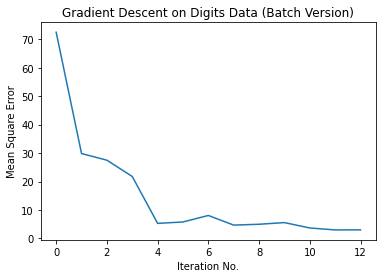

In [8]:
# Running Gradient Descent on OCR
# Load the digits dataset with two classes
digits,target = dt.load_digits(n_class=2,return_X_y=True)
# Split into train and test set
x_train, x_test, y_train, y_test = train_test_split(
                        digits, target, test_size=0.2, random_state=10)

# Add a column of ones to account for bias in train and test
x_train = np.hstack((np.ones((y_train.size,1)),x_train))
x_test  = np.hstack((np.ones((y_test.size,1)),x_test))

# Initialize the weights and call gradient descent
rand = np.random.RandomState(19)
w_init = rand.uniform(-1,1,x_train.shape[1])*.000001
w_history,mse_history = gradient_descent(100,0.1,w_init,
                              mse,grad_mse,(x_train,y_train),
                             learning_rate=1e-6,momentum=0.7)

# Plot the MSE
plt.plot(np.arange(mse_history.size),mse_history)
plt.xlabel('Iteration No.')
plt.ylabel('Mean Square Error')
plt.title('Gradient Descent on Digits Data (Batch Version)')
plt.show()

In [11]:
# Returns error rate of classifier
# total miclassifications/total*100
def error(w,xy):
    (x,y) = xy
    o = np.sum(x*w,axis=1)
    
    #map the output values to 0/1 class labels
    ind_1 = np.where(o>0.5)
    ind_0 = np.where(o<=0.5)
    o[ind_1] = 1
    o[ind_0] = 0
    return np.sum((o-y)*(o-y))/y.size*100
    
train_error = error(w_history[-1],(x_train,y_train))
test_error = error(w_history[-1],(x_test,y_test))

print("Train Error Rate: " + "{:.2f}".format(train_error))
print("Test Error Rate: " + "{:.2f}".format(test_error))

Train Error Rate: 0.69
Test Error Rate: 1.39


# Stochastic Gradient Descent Function 

max_iterations: Maximum number of iterations to run

threshold: Stop if the difference in function values between two successive iterations falls below this threshold

w_init: Initial point from where to start gradient descent

obj_func: Reference to the function that computes the objective function

grad_func: Reference to the function that computes the gradient of the function

extra_param: Extra parameters (if needed) for the obj_func and grad_func

learning_rate: Step size for gradient descent. It should be in [0,1]

momentum: Momentum to use. It should be in [0,1]


Also, the function will return:

w_history: All points in space, visited by gradient descent at which the objective function was evaluated

f_history: Corresponding value of the objective function computed at each point

In [14]:
# (xy) is the (training_set,target) pair
def stochastic_gradient_descent(max_epochs,threshold,w_init,
                                obj_func,grad_func,xy,
                                learning_rate=0.05,momentum=0.8):
    (x_train,y_train) = xy
    w = w_init
    w_history = w
    f_history = obj_func(w,xy)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    rows = x_train.shape[0]
    
    # Run epochs
    while  i<max_epochs and diff>threshold:
        # Shuffle rows using a fixed seed to reproduce the results
        # Use the seed() method to customize the start number of the random number generator.
        np.random.seed(i)
        p = np.random.permutation(rows)
        
        # Run for each instance/example in training set
        for x,y in zip(x_train[p,:],y_train[p]):
            delta_w = -learning_rate*grad_func(w,(np.array([x]),y)) + momentum*delta_w
            w = w+delta_w
            
        i+=1
        w_history = np.vstack((w_history,w))
        f_history = np.vstack((f_history,obj_func(w,xy)))
        diff = np.absolute(f_history[-1]-f_history[-2])
        
    return w_history,f_history

# Stochastic  Descent for Minimizing Mean Square Error


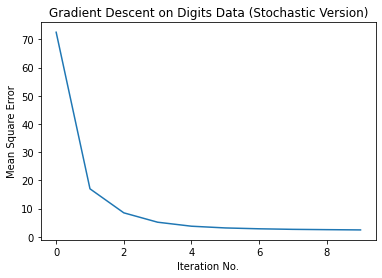

In [15]:
rand = np.random.RandomState(19)
w_init = rand.uniform(-1,1,x_train.shape[1])*.000001
w_history_stoch,mse_history_stoch = stochastic_gradient_descent(
                                100,0.1,w_init,
                              mse,grad_mse,(x_train,y_train),
                             learning_rate=1e-6,momentum=0.7)

# Plot the MSE
plt.plot(np.arange(mse_history_stoch.size),mse_history_stoch)
plt.xlabel('Iteration No.')
plt.ylabel('Mean Square Error')
plt.title('Gradient Descent on Digits Data (Stochastic Version)')

plt.show()

In [16]:
train_error_stochastic = error(w_history_stoch[-1],(x_train,y_train))
test_error_stochastic = error(w_history_stoch[-1],(x_test,y_test))

print("Train Error rate with Stochastic Gradient Descent: " + 
      "{:.2f}".format(train_error_stochastic))
print("Test Error rate with Stochastic Gradient Descent: "  
      + "{:.2f}".format(test_error_stochastic))

Train Error rate with Stochastic Gradient Descent: 0.35
Test Error rate with Stochastic Gradient Descent: 1.39


In [17]:
## Comparing Batch and Stochastic Versions


Momentum = 0
	Batch:
		Train error: 0.35
		Test error: 1.39
	Stochastic:
		Train error: 0.35
		Test error: 1.39
Momentum = 0.5
	Batch:
		Train error: 0.35
		Test error: 1.39
	Stochastic:
		Train error: 0.35
		Test error: 1.39
Momentum = 0.9
	Batch:
		Train error: 0.00
		Test error: 1.39
	Stochastic:
		Train error: 0.00
		Test error: 1.39


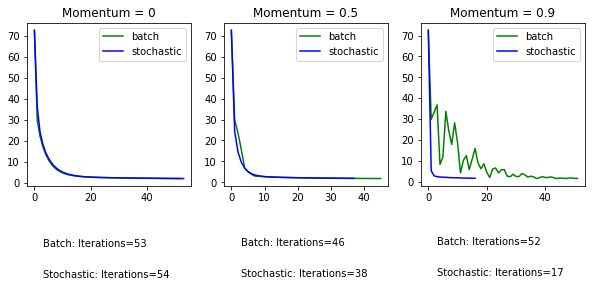

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,3))

rand = np.random.RandomState(11)
w_init = rand.uniform(-1,1,x_train.shape[1])*.000001
eta = 1e-6
for alpha,ind in zip([0,0.5,0.9],[1,2,3]):
    w_history,mse_history = gradient_descent(
                                100,0.01,w_init,
                              mse,grad_mse,(x_train,y_train),
                             learning_rate=eta,momentum=alpha)
    w_history_stoch,mse_history_stoch = stochastic_gradient_descent(
                                100,0.01,w_init,
                              mse,grad_mse,(x_train,y_train),
                             learning_rate=eta,momentum=alpha)
    
    # Plot the MSE
    plt.subplot(130+ind)
    plt.plot(np.arange(mse_history.size),mse_history,color='green')
    plt.plot(np.arange(mse_history_stoch.size),mse_history_stoch,color='blue')
    plt.legend(['batch','stochastic'])
    
    # Display total iterations
    plt.text(3,-30,'Batch: Iterations='+
             str(mse_history.size) )
    plt.text(3,-45,'Stochastic: Iterations='+
             str(mse_history_stoch.size))
    plt.title('Momentum = ' + str(alpha))   
    
    # Display the error rates
    train_error = error(w_history[-1],(x_train,y_train))
    test_error = error(w_history[-1],(x_test,y_test))
    
    train_error_stochastic = error(w_history_stoch[-1],(x_train,y_train))
    test_error_stochastic = error(w_history_stoch[-1],(x_test,y_test))
    
    print ('Momentum = '+str(alpha))
    
    print ('\tBatch:')
    print ('\t\tTrain error: ' + "{:.2f}".format(train_error) )
    print ('\t\tTest error: ' + "{:.2f}".format(test_error) )
    
    print ('\tStochastic:')
    print ('\t\tTrain error: ' + "{:.2f}".format(train_error_stochastic) )
    print ('\t\tTest error: ' + "{:.2f}".format(test_error_stochastic) )
    
        
plt.show()

# Stochastic Processes Simulation

### Brownian Motion or Wiener Process


In [2]:
#50value for xt
for i in range(0, 50):
    xt = 0 + norm.rvs(scale=1**2* 4)

In [4]:
# Generate Brownian Function
def generate_brownian(x0, n, dt, delta, output=None):
    x0 = np.asarray(x0)
    r = norm.rvs(size=x0.shape + (n,), scale=delta* np.sqrt(dt))
    if output is None:
        output = np.empty(r.shape) 
        
    np.cumsum(r, axis=-1, out = output)
    output += np.expand_dims(x0, axis=-1)

    return output

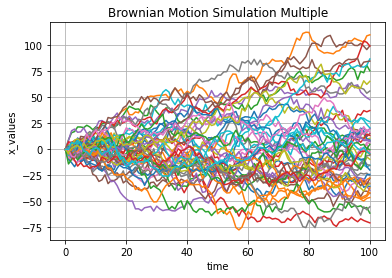

In [9]:
#ploting the 50 simulations
x = np.empty((50,101))
x[:, 0] = 0

generate_brownian(x[:, 0], 100, 1, 4, output=x[:,1:])

time = np.linspace(0, 100, 101)
for k in range(50):
    plt.plot(time, x[k])
plt.title('Brownian Motion Simulation Multiple')
plt.xlabel('time')
plt.ylabel('x_values')
plt.grid(True)
plt.show()

### Poisson Processs


In [12]:
#poisson process function
def poisson_process(lambdas, number):
    X_T = np.random.poisson(lambdas, size=number)
    S = [np.sum(X_T[0:i]) for i in range(number)]
    X = np.linspace(0, number, number)
    graphs = [plt.step(X, S, label="Lambda = %d"%lambdas)[0] for i in range(lambdas)]
    graph = plt.step(X, S, label="Lambda = %d"%lambdas)
    plt.legend(handles=graph, loc=2)
    plt.title('Poisson Process')
    plt.xlabel('time')
    plt.ylabel('intensity')

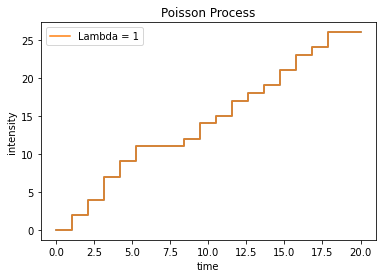

In [13]:
poisson_process(1, 20)
plt.show()

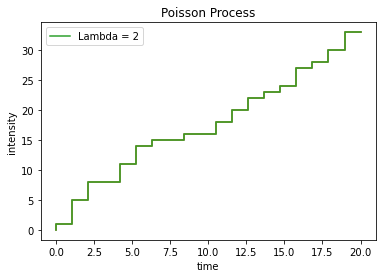

In [14]:
poisson_process(2, 20)
plt.show()

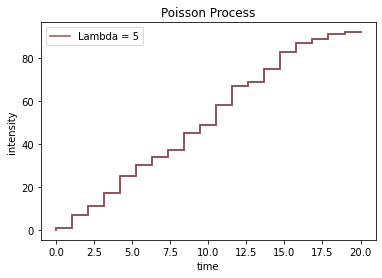

In [15]:
#increasing the value of lamda
poisson_process(5, 20)
plt.show()

In [16]:
# Increasing the value of lamda and number

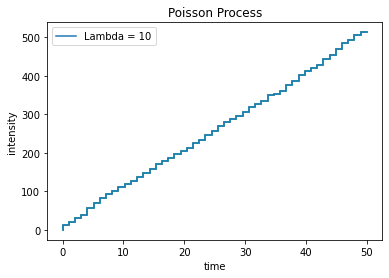

In [17]:
poisson_process(10, 50)
plt.show()